# Import Library

In [1]:
import numpy as np
import os
import networkx as nx
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras import Sequential, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from layers import GraphConv
from models import GCN, DNN
from utils import (
    seed_everything, 
    limit_data, 
    encode_label, 
    normalize_Adj,
    draw_history,
    plot_tSNE,
)
import config as C

#### Set Seed

In [2]:
seed_everything(C.SEED)

# Cora Dataset 

In [3]:
all_data = []
all_edges = []

for root, dirs, files in os.walk(C.DATA_PATH):
    for file in files:
        if '.content' in file:
            with open(os.path.join(root, file), 'r') as f:
                all_data.extend(f.read().splitlines())
        elif '.cites' in file:
            with open(os.path.join(root, file), 'r') as f:
                all_edges.extend(f.read().splitlines())

all_data = shuffle(all_data, random_state=C.SEED)

cora.content
1. Node ID
2. Node Feature
3. Node Label

cora.cites

(a, b)

a : ID of the paper being cited

b : the paper containing the citation

In [4]:
labels = []
nodes = []
X = []

for i, data in enumerate(all_data):
    elements = data.split('\t')
    labels.append(elements[-1])
    X.append(elements[1:-1])
    nodes.append(elements[0])
    
X = np.array(X, dtype=int)
N = X.shape[0]
F = X.shape[1]
print(f'LOG >>> X shape: {X.shape}')

LOG >>> X shape: (2708, 1433)


In [5]:
edge_list = []

for edge in all_edges:
    e = edge.split('\t')
    edge_list.append((e[0], e[1]))
    
print(f'LOG >>> Number of Nodes N : {N}')
print(f'LOG >>> Number of Features F of each node : {F}')
print(f'LOG >>> Categories :\n{set(labels)}')
# num_classes = len(set(labels))
print(f'LOG >>> Number of classes : {C.num_classes}')

LOG >>> Number of Nodes N : 2708
LOG >>> Number of Features F of each node : 1433
LOG >>> Categories :
{'Rule_Learning', 'Probabilistic_Methods', 'Case_Based', 'Theory', 'Genetic_Algorithms', 'Reinforcement_Learning', 'Neural_Networks'}
LOG >>> Number of classes : 7


In [6]:
len(edge_list)

5429

# Set Train, val and test mask 

In [6]:
train_idx, val_idx, test_idx = limit_data(labels)

In [7]:
print(f'LOG >>> Number of Train set : {len(train_idx)}')
print(f'LOG >>> Number of Valid set : {len(val_idx)}')
print(f'LOG >>> Number of Test set : {len(test_idx)}')

LOG >>> Number of Train set : 140
LOG >>> Number of Valid set : 500
LOG >>> Number of Test set : 1000


In [8]:
train_mask = np.zeros((N,), dtype=bool)
train_mask[train_idx] = True

val_mask = np.zeros((N,), dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((N,), dtype=bool)
test_mask[test_idx] = True

### Get Adjacency Matrix, A 

In [9]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)

A = nx.adjacency_matrix(G)
print(f'LOG >>> Graph info:\n{nx.info(G)}')

# Normalize A and convert type of X
A = normalize_Adj(A)
X = X.astype(np.float64)

LOG >>> Graph info:
Name: 
Type: Graph
Number of nodes: 2708
Number of edges: 5278
Average degree:   3.8981


### Encode label with One-Hot

In [10]:
labels_encoded, classes = encode_label(labels)

# Raw Data 

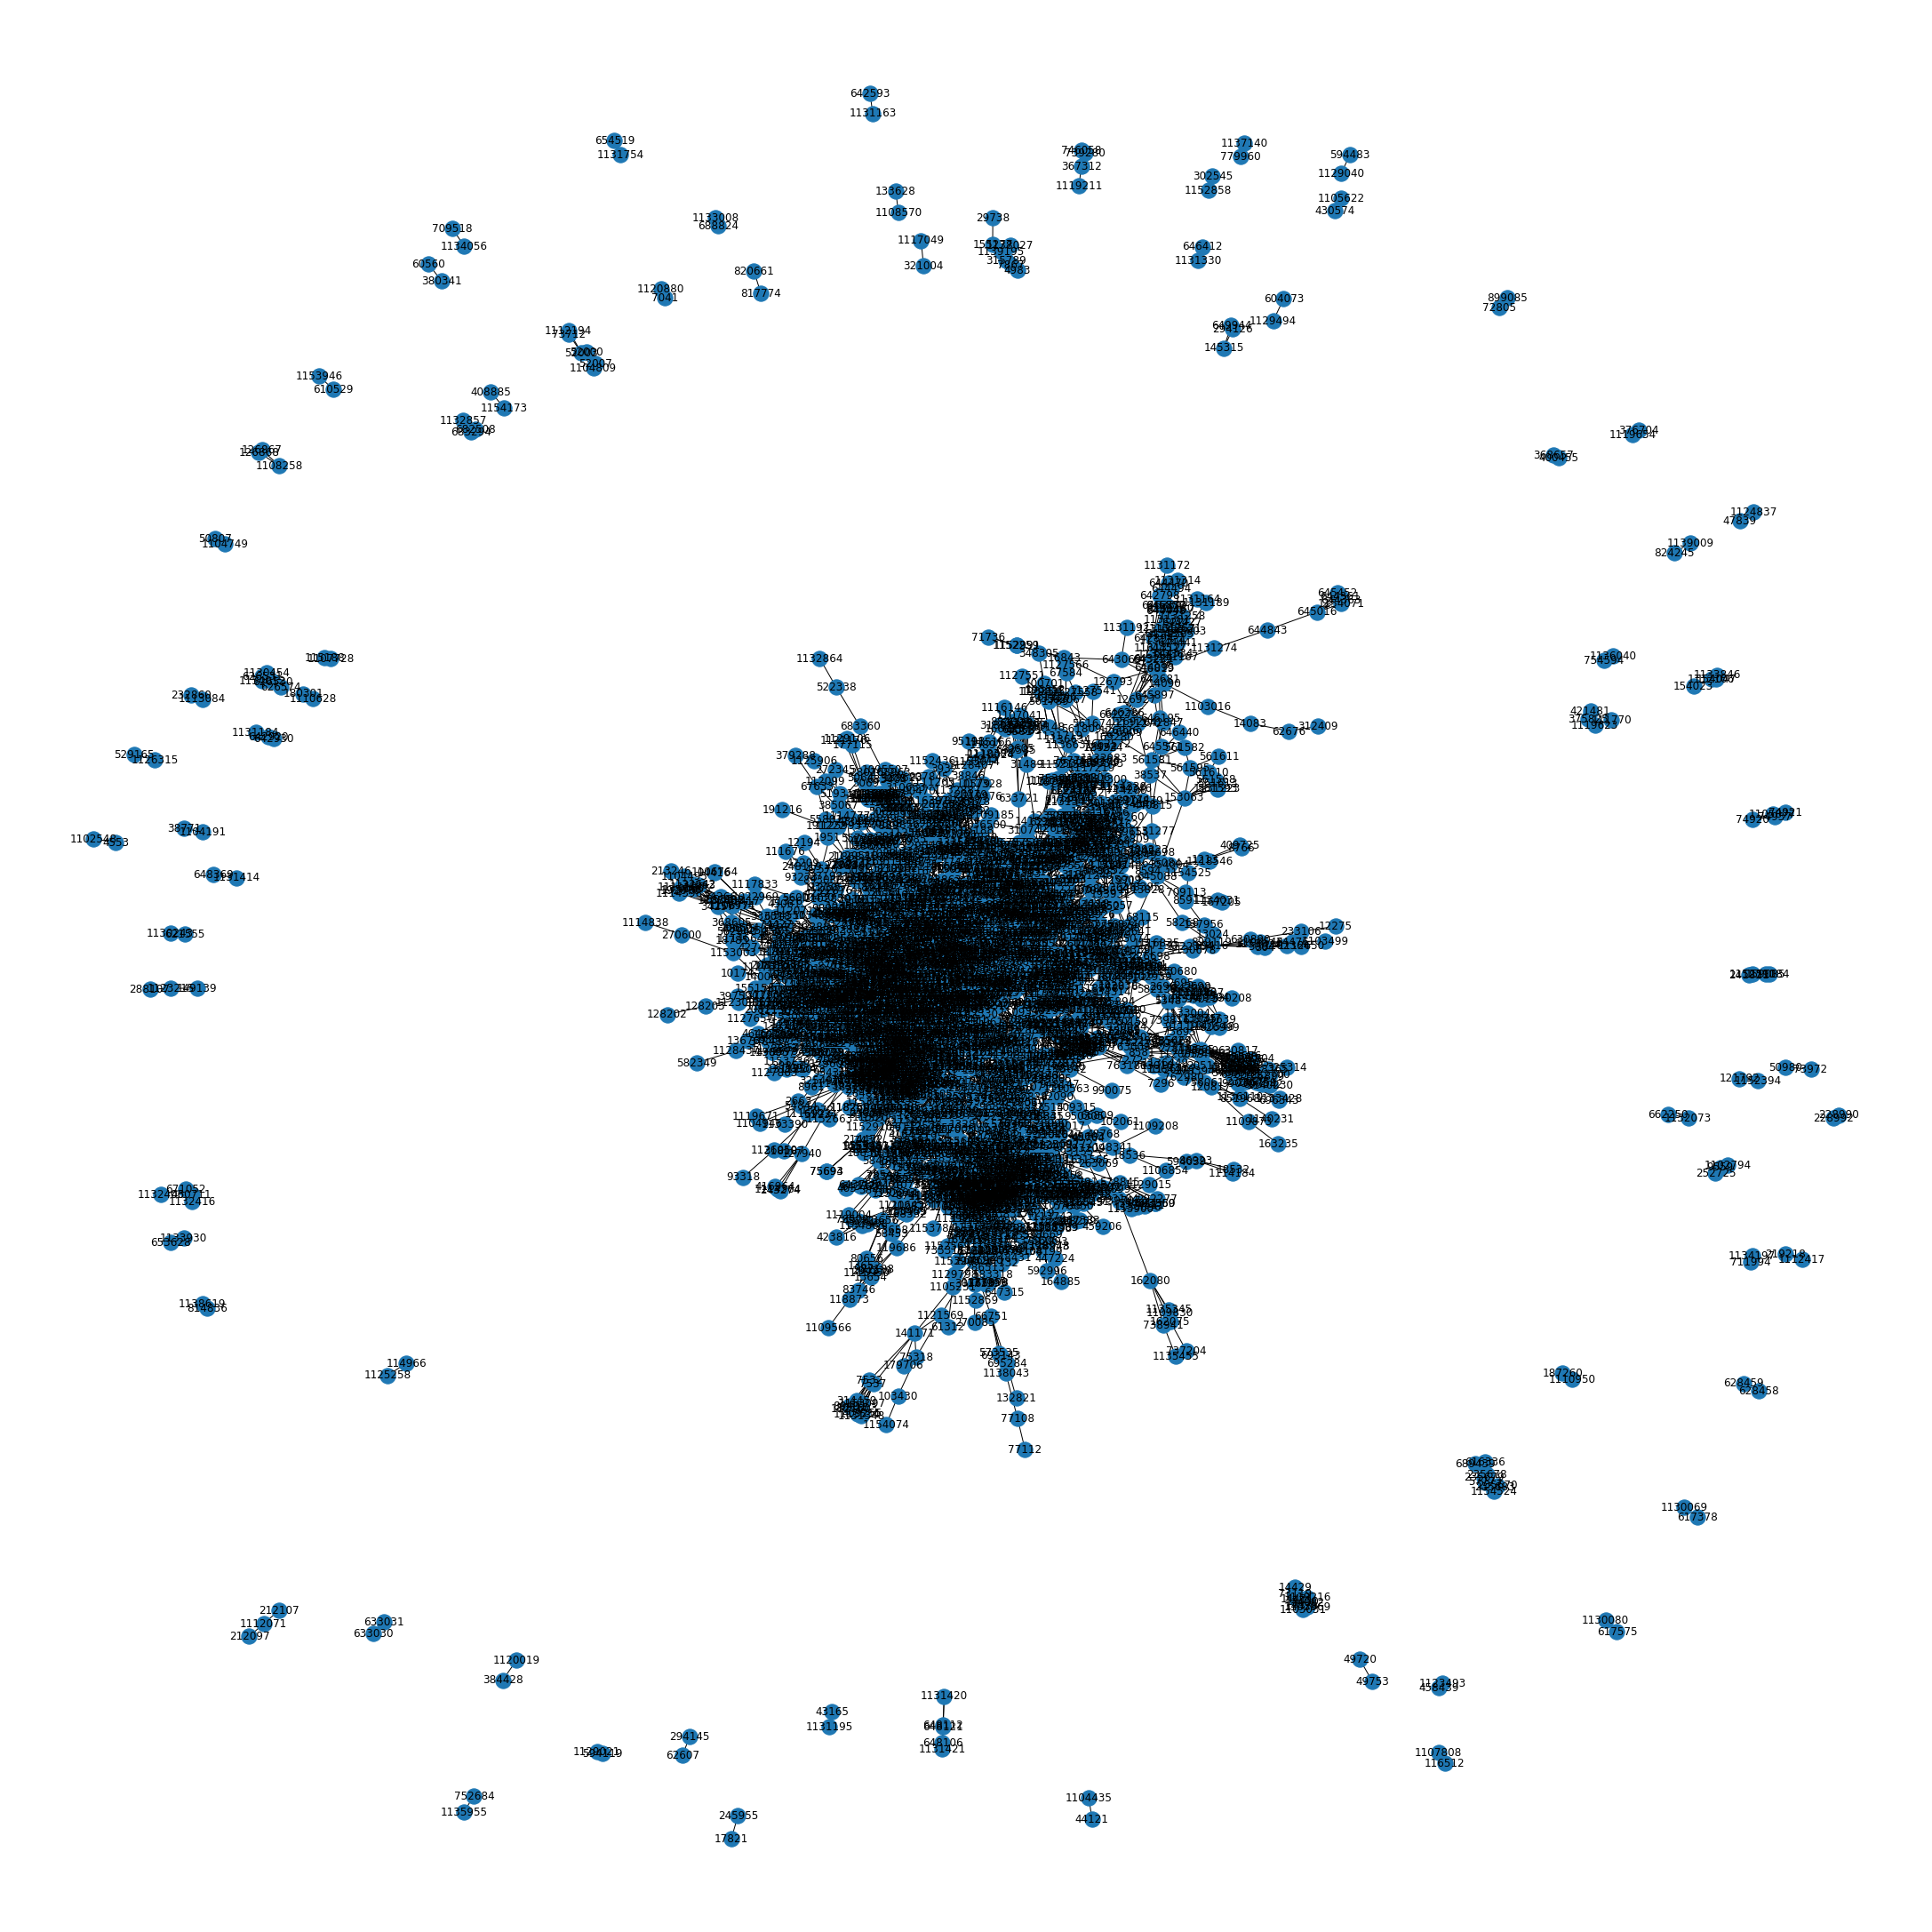

In [11]:
plt.figure(figsize=(30, 30))
nx.draw(G, with_labels=True)
plt.show()

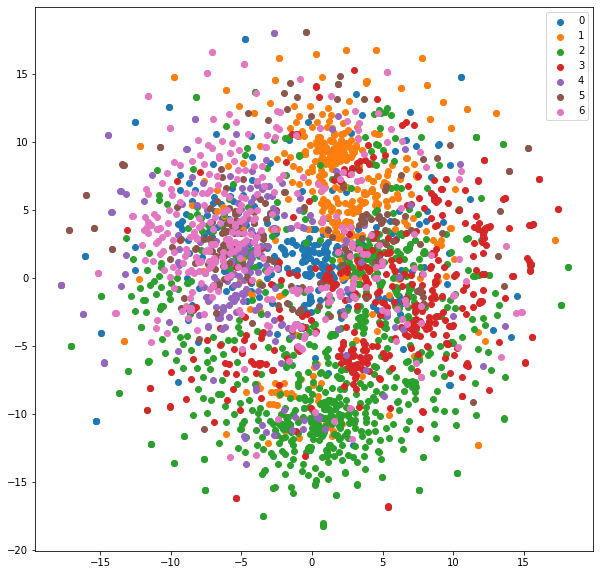

In [12]:
raw_x = TSNE(n_components=2).fit_transform(X)

plot_tSNE(labels_encoded, raw_x)

# GCN

#### Build Model 

In [13]:
model = GCN(C.GCN_filters, C.dropout)

optimizer = Adam(lr=C.learning_rate)
model.compile(optimizer=optimizer,
             loss='categorical_crossentropy',
             weighted_metrics=['acc'])

#### Callbacks

In [14]:
# tensorboard = tf.keras.callbacks.TensorBoard(log_dir=C.LOG_PATH)
early_stop = tf.keras.callbacks.EarlyStopping(patience=C.es_patience, restore_best_weights=True)

# callbacks = [tensorboard, early_stop]
callbacks = [early_stop]

#### Make Valid data 

In [15]:
validation_data = ([A, X], labels_encoded, val_mask)

#### Training 

Epoch 1/200
1/1 [==============================] - 1s 870ms/step - loss: 0.1018 - acc: 0.0643 - val_loss: 0.3552 - val_acc: 0.2300
Epoch 2/200
1/1 [==============================] - 0s 108ms/step - loss: 0.0983 - acc: 0.2214 - val_loss: 0.3484 - val_acc: 0.3080
Epoch 3/200
1/1 [==============================] - 0s 107ms/step - loss: 0.0944 - acc: 0.4857 - val_loss: 0.3394 - val_acc: 0.3600
Epoch 4/200
1/1 [==============================] - 0s 106ms/step - loss: 0.0909 - acc: 0.4714 - val_loss: 0.3285 - val_acc: 0.3960
Epoch 5/200
1/1 [==============================] - 0s 105ms/step - loss: 0.0855 - acc: 0.5786 - val_loss: 0.3170 - val_acc: 0.3960
Epoch 6/200
1/1 [==============================] - 0s 106ms/step - loss: 0.0787 - acc: 0.6000 - val_loss: 0.3065 - val_acc: 0.3920
Epoch 7/200
1/1 [==============================] - 0s 107ms/step - loss: 0.0757 - acc: 0.5714 - val_loss: 0.2958 - val_acc: 0.4120
Epoch 8/200
1/1 [==============================] - 0s 106ms/step - loss: 0.0701 - a

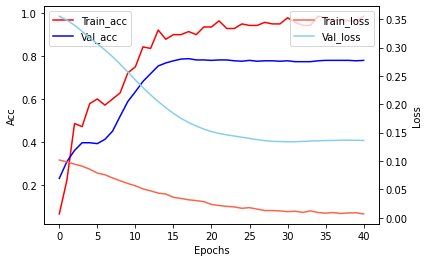

In [16]:
history = model.fit([A, X],
         labels_encoded,
         sample_weight=train_mask,
         epochs=C.epochs,
         batch_size=N,
         validation_data=validation_data,
         shuffle=False,
         callbacks=callbacks)

draw_history(history, 'GCN')

#### Evaluate 

In [17]:
X_te = X[test_mask]
A_te = A[test_mask, :][:, test_mask]
y_te = labels_encoded[test_mask]

y_pred = model.predict([A_te, X_te], batch_size=N)
report = classification_report(np.argmax(y_te, axis=1),
                              np.argmax(y_pred, axis=1),
                              target_names=classes)
print(f'LOG >>> GCN Classification Report:\n{report}')

LOG >>> GCN Classification Report:
                        precision    recall  f1-score   support

            Case_Based       0.72      0.74      0.73       113
    Genetic_Algorithms       0.89      0.84      0.87       150
       Neural_Networks       0.86      0.63      0.73       306
 Probabilistic_Methods       0.80      0.72      0.76       167
Reinforcement_Learning       0.71      0.85      0.77        79
         Rule_Learning       0.53      0.82      0.65        62
                Theory       0.46      0.66      0.54       123

              accuracy                           0.72      1000
             macro avg       0.71      0.75      0.72      1000
          weighted avg       0.76      0.72      0.73      1000



####  Visualization

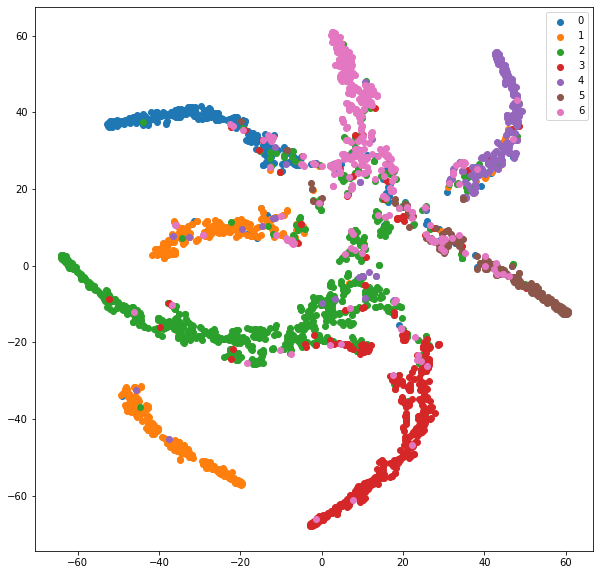

In [18]:
activations = model.predict([A, X], batch_size=N)

x_tsne = TSNE(n_components=2).fit_transform(activations)

plot_tSNE(labels_encoded, x_tsne)

# DNN

#### Build Model 

In [19]:
DNN_model = DNN([128, 256], C.dropout)

DNN_model.compile(optimizer=Adam(1e-2),
           loss='categorical_crossentropy',
           weighted_metrics=['acc'])

#### Callbacks 

In [20]:
dnn_early_stop = EarlyStopping(patience=C.es_patience, restore_best_weights=True)

callbacks=[dnn_early_stop]

#### Make Valid data 

In [21]:
DNN_valid_data = (X, labels_encoded, val_mask)

#### Training 

Epoch 1/200
1/1 [==============================] - 1s 529ms/step - loss: 0.3041 - acc: 0.1143 - val_loss: 0.5058 - val_acc: 0.2480
Epoch 2/200
1/1 [==============================] - 0s 35ms/step - loss: 0.2468 - acc: 0.2929 - val_loss: 0.4612 - val_acc: 0.3480
Epoch 3/200
1/1 [==============================] - 0s 34ms/step - loss: 0.2025 - acc: 0.4643 - val_loss: 0.4275 - val_acc: 0.3960
Epoch 4/200
1/1 [==============================] - 0s 34ms/step - loss: 0.1670 - acc: 0.6143 - val_loss: 0.3980 - val_acc: 0.4700
Epoch 5/200
1/1 [==============================] - 0s 33ms/step - loss: 0.1414 - acc: 0.7357 - val_loss: 0.3699 - val_acc: 0.5200
Epoch 6/200
1/1 [==============================] - 0s 33ms/step - loss: 0.1143 - acc: 0.8429 - val_loss: 0.3423 - val_acc: 0.5360
Epoch 7/200
1/1 [==============================] - 0s 34ms/step - loss: 0.0964 - acc: 0.8857 - val_loss: 0.3133 - val_acc: 0.5700
Epoch 8/200
1/1 [==============================] - 0s 35ms/step - loss: 0.0795 - acc: 0.9

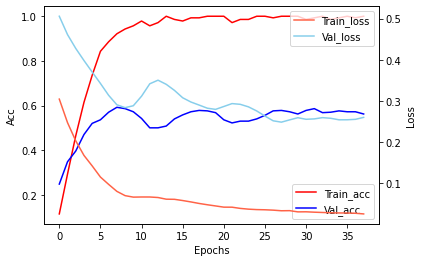

In [22]:
DNN_history = DNN_model.fit(X,
       labels_encoded,
       sample_weight=train_mask,
       epochs=C.epochs,
       batch_size=N,
       validation_data=DNN_valid_data,
       shuffle=False,
       callbacks=callbacks)

draw_history(DNN_history, 'DNN')

#### Evaluate 

In [23]:
X_te = X[test_mask]
y_te = labels_encoded[test_mask]

y_pred = DNN_model.predict(X_te, batch_size=N)

DNN_report = classification_report(np.argmax(y_te, axis=1),
                              np.argmax(y_pred, axis=1),
                              target_names=classes)
print(f'LOG >>> DNN Classification Report:\n{DNN_report}')

LOG >>> DNN Classification Report:
                        precision    recall  f1-score   support

            Case_Based       0.59      0.50      0.54       113
    Genetic_Algorithms       0.68      0.69      0.69       150
       Neural_Networks       0.63      0.59      0.61       306
 Probabilistic_Methods       0.56      0.50      0.53       167
Reinforcement_Learning       0.72      0.61      0.66        79
         Rule_Learning       0.37      0.60      0.46        62
                Theory       0.41      0.48      0.44       123

              accuracy                           0.57      1000
             macro avg       0.56      0.57      0.56      1000
          weighted avg       0.58      0.57      0.57      1000



#### Visualilzation 

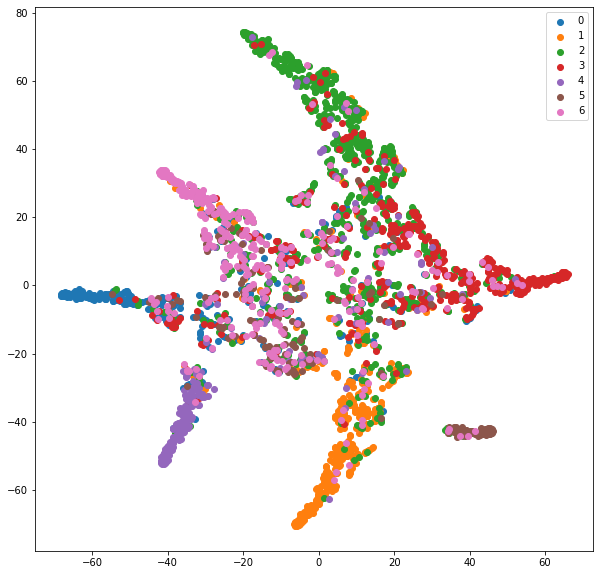

In [24]:
activations = DNN_model.predict(X)

dnn_x_tsne = TSNE(n_components=2).fit_transform(activations)
plot_tSNE(labels_encoded, dnn_x_tsne)